### IMPORT PACKAGES

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

### FUNCTION

In [2]:
#split feature columns
def group_feature(df=pd.DataFrame):
    numeric = list(df.select_dtypes(include=[int,float]))
    category = list(df.select_dtypes(exclude=[int,float]))
    return numeric,category

#function check outlier
def check_outliers(column = str, df = pd.DataFrame):
    values = {}
    for j,i in enumerate(column):
        print(j,i)
        Q3 = df[i].quantile(q=0.75)
        Q1 = df[i].quantile(q=0.25)
        IQR = Q3 - Q1
        min_IQR = Q1 - 1.5 * IQR
        max_IQR = Q3 + 1.5 * IQR
        results_top = []
        results_down = []
        for index,val in enumerate(df[i]):
            if (val < min_IQR):
                results_down.append(val)
            elif (val > max_IQR):
                results_top.append(val)
        print(f"column :{i}\nnum_outliers:{len(results_top) + len(results_down)}\n")
        values [j] = [results_top,results_down]
    return values

#Variance Inlfuencer Factor Table
def VIF_table(X_dataframe:pd.DataFrame):
    VIF_value  =[variance_inflation_factor(X_dataframe.values,i) for i in range(len(X_dataframe.columns))]
    VIF_columns = list(X_dataframe.columns)
    
    return pd.DataFrame({'col' : VIF_columns,'val' :VIF_value})

### BUSSINESS UNDERSTANDING
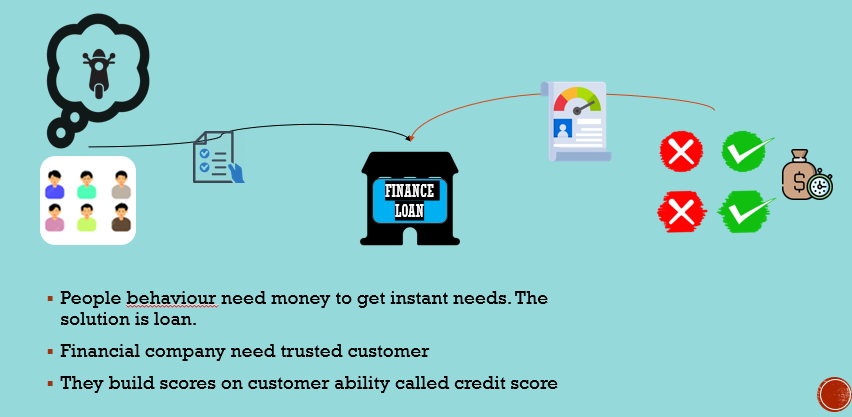

PURPOSE = To predict CREDIT SCORE as integer (350-850), berdasarkan data pemohon kredit potensial. yang berarti semakin tinggi skor pemohon dapat terpercaya diberikan pinjaman kredit untuk motor di india.

Value = meminimalisir kerugian akibat peminjam yang tidak membayar atau telat membayar
matrix = rmse dan mse 

example :

1 lakh = 100.000 rupee
ir = interest rate/suku bunga

range two wheeler loan 1-50 lakh:

8-12 % = loan with low interest rate, 50 lakh , ir 8% = 400.000, if in a year  
base 416.666 rupee/month + ir 33.333 rupee/month = 450.000/5000.000 = 9 %  minimize loss for the first month onward

12-15 % = loan with normal interest rate, 50 lakh , ir 12% = 600.000, if in a year  
base 416.666 rupee/month + ir 50.000 rupee/month = 466.666/5000.000 = 9,3 %  minimize loss for the first month onward

15-20 % = loan with high interest rate, 50 lakh , ir 15% = 750.000, if in a year  
base 416.666 rupee/month + ir 62.500 rupee/month = 479.166/5000.000 = 9,5 % minimize loss for the first month onwards

20-25 % = no loan or high interest rate if do loan, 50 lakh / 5.000.000 rupee,ir 20% =  1000.000, if in a year 
base 416.666 rupee/month + ir 83.333 rupee/month = 500.000/ 5000.000 = 10 % we can minimize loss up to 10 % for the first month onwards.

for credit score below 300 (base on fico credit score), we can reject loan submission and save 100 % / 50 lakh for the highest loan value

### cibil score (india) source IIFL finance.com

Excellent Credit Score - Around 750 and above
These Individuals are likely to have a high likelihood of loan approval and can access loans and credit at favourable terms, including lower interest rates.

Good Credit Score - In the range of 700 to 749
This scoring range also signifies a strong credit profile, and individuals within this range are generally considered reliable borrowers by lenders.

Fair Credit Score - Ranges from 650 to 699
Individuals with fair credit scores can have access to credit, but they might face slightly higher interest rates or more stringent lending conditions than those with higher scores.

Poor Credit Score - Below 650
They may face challenges in obtaining credit or loans as lenders may be more cautious due to the perceived higher credit risk.


### Fico credit score (US) mybanktracker.com 

300-580	Very Bad:	
Extremely difficult to obtain traditional loans and line of credit. Advised to use secured credit cards and loans to help rebuild credit.

580-669	Bad:
May be able to qualify for some loans and lines of credit, but the interest rates are likely to be high.

670-739	Average/Fair:
Eligible for many traditional loans, but the interest rates and terms may not be the best.

740-799	Good:
Valuable benefits come in the form of loans and lines of credit with comprehensive perks and low interest rates.

800-850	Excellent:
Qualify easily for most loans and lines of credit with low interest rates and favorable terms.

In [3]:
#read data

df = pd.read_csv('C:/Users/hp/Downloads/NEW PROJECT/credit_data.csv')
df.head(3)

,Age,Gender,Income,Credit Score,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,Existing Customer,State,City,LTV Ratio,Employment Profile,Profile Score,Occupation
0,31,Male,36000,604,487,5,109373,221,No,Karnataka,Mysuru,90.943430,Salaried,77,Doctor
1,25,Male,50000,447,386,2,150000,89,No,Karnataka,Bengaluru,91.135253,Salaried,43,Software Engineer
2,62,Other,178000,850,503,10,69099,110,Yes,Uttar Pradesh,Kanpur,40.000000,Salaried,90,Banker


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279856 entries, 0 to 279855
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       279856 non-null  int64  
 1   Gender                    279856 non-null  object 
 2   Income                    279856 non-null  int64  
 3   Credit Score              279856 non-null  int64  
 4   Credit History Length     279856 non-null  int64  
 5   Number of Existing Loans  279856 non-null  int64  
 6   Loan Amount               279856 non-null  int64  
 7   Loan Tenure               279856 non-null  int64  
 8   Existing Customer         279856 non-null  object 
 9   State                     279856 non-null  object 
 10  City                      279856 non-null  object 
 11  LTV Ratio                 279856 non-null  float64
 12  Employment Profile        279856 non-null  object 
 13  Profile Score             279856 non-null  i

### DICTIONARY

Age:
Type: Integer\
Description: Represents the age of the applicant. Indicates the applicant's maturity level.\
Range: 18 to 70

Gender:
Type: Categorical\
Description: Gender of the applicant.\
Categories: Male, Female, Other

Income:
Type: Integer\
Description: The applicant's income, which is critical in assessing their ability to repay the loan.\
Range: Multiples of 1000's

Credit Score:
Type: Integer\
Description: A score quantifying the applicant's creditworthiness based on their credit history.\
Range: 300 to 850

Credit History Length:
Type: Integer\
Description: Represents the number of months since the applicant's first credit line. Indicates the applicant's experience with credit management.\
Units: Months

Number of Existing Loans:
Type: Integer\
Description: The number of loans the applicant currently has.\
Range: 0 to 10

Loan Amount:
Type: Integer\
Description: The amount of money the applicant is requesting.\
Range: 0 to 150,000

Loan Tenure:
Type: Integer\
Description: The number of months the applicant wants to repay the loan over.\
Units: Months

Existing Customer:
Type: Categorical\
Description: Whether the applicant is an existing customer of the finance company.\
Categories: Yes, No

State:
Type: Categorical\
Description: The state in India where the applicant resides.\
Categories: Maharashtra, Delhi, Karnataka, Tamil Nadu, West Bengal, Uttar Pradesh, Gujarat, Rajasthan, Kerala, Telangana, etc.

City:
Type: Categorical\
Description: The city or village in India where the applicant resides.\
Categories: Mumbai, Pune, New Delhi, Bengaluru, Chennai, Kolkata, Ahmedabad, Jaipur, Kochi, Hyderabad, and various villages.

LTV Ratio:
Type: Float\
Description: The loan-to-value ratio, represents the ratio of the loan amount to the appraised value of the asset (typically a house). Higher LTVs can indicate higher risk.\
Range: 40% to 95%

Employment Profile:
Type: Categorical\
Description: General employment category of the applicant.\
Categories: Salaried, Self-Employed, Freelancer, Unemployed, Student

Occupation:
Type: Categorical\
Description: Specific occupation or job title of the applicant.\
Categories: Software Engineer, Doctor, Teacher, Business Owner, Writer, etc.

Profile Score:
Type: Integer\
Description: A score ranging from 0 to 100 represents the overall profile of the applicant based on the actual loan repayment data. Higher values indicate better profiles.\
Range: 0 to 100

Property Value:
type : float\
Description : Value the reason customer want to loan (two wheel's value)

### DATA PREPARATION

In [4]:
# menambahkan fitur property value

df['Property Value'] = round(df['Loan Amount'] / (df['LTV Ratio'] / 100),2)

In [6]:
#duplicated handling

df.duplicated(subset=list(df.columns)).sum()
# ada banyak sekali record double

100814

In [7]:
#value check
df[df.duplicated(subset=list(df.columns),keep=False)].sort_values(by= list(df.columns)).head(3)

,Age,Gender,Income,Credit Score,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,Existing Customer,State,City,LTV Ratio,Employment Profile,Profile Score,Occupation,Property Value
22723,18,Female,9000,300,500,0,36631,26,No,West Bengal,Kolkata,95.000000,Salaried,24,Software Engineer,38558.95
176804,18,Female,9000,300,500,0,36631,26,No,West Bengal,Kolkata,95.000000,Salaried,24,Software Engineer,38558.95
137592,18,Female,9000,328,235,0,44422,112,No,West Bengal,Kolkata,84.429872,Salaried,57,Doctor,52614.08


In [5]:
#drop duplicated row
df = df.drop_duplicates(subset=list(df.columns))

In [9]:
#check missing value
df.isnull().sum()

Age                             0
Gender                          0
Income                          0
Credit Score                    0
Credit History Length           0
Number of Existing Loans        0
Loan Amount                     0
Loan Tenure                     0
Existing Customer               0
State                           0
City                            0
LTV Ratio                       0
Employment Profile              0
Profile Score                   0
Occupation                  11690
Property Value                  0
dtype: int64

In [9]:
11690/ len(df)
# ada 0.06 % missing value pada occupation

0.06529194267266898

<AxesSubplot:>

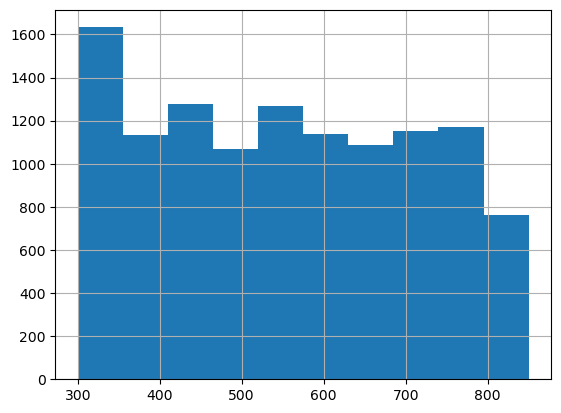

In [9]:
ds = df[df['Occupation'].isnull()]
ds['Credit Score'].hist()

#nilai null mengarah ke lebih banyak yang credit score menengah hingga rendah namun tidak signifikan

In [10]:
ds['Employment Profile'].unique()

#yang missing value merupakan yang tidak bekerja

array(['Unemployed'], dtype=object)

In [10]:
df[df['Employment Profile'] == 'Unemployed'].head(5)

,Age,Gender,Income,Credit Score,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,Existing Customer,State,City,LTV Ratio,Employment Profile,Profile Score,Occupation
25,61,Female,41000,307,104,0,23296,99,No,Rajasthan,Udaipur,58.686622,Unemployed,23,NaN
28,52,Female,87000,697,26,7,141231,70,Yes,Delhi,New Delhi,94.616809,Unemployed,58,NaN
31,57,Female,130000,850,600,10,56891,195,Yes,Telangana,Hyderabad,40.481983,Unemployed,96,NaN
33,53,Male,33000,428,576,2,99179,56,No,Delhi,New Delhi,53.836170,Unemployed,62,NaN
41,18,Other,16000,329,436,0,12592,119,No,Telangana,Hyderabad,94.802565,Unemployed,17,NaN


In [6]:
#change missing value
df['Occupation'] = np.where(df['Occupation'].isnull(), 'None',df['Occupation'])
# df = df.dropna(subset='Occupation')

In [12]:
#check target value
print('credit score:','\n','min',df['Credit Score'].min(),'\n','max:',df['Credit Score'].max())

credit score: 
 min 300 
 max: 850


<AxesSubplot:>

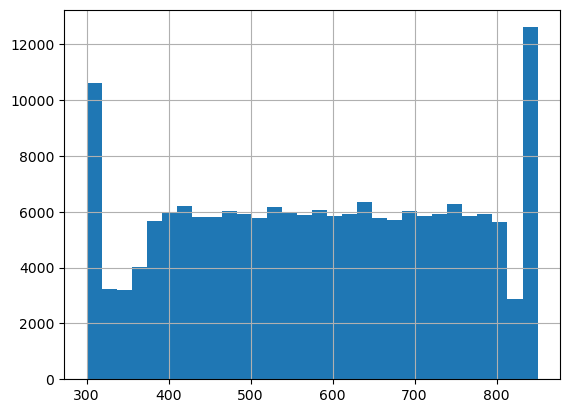

In [13]:
df['Credit Score'].hist(bins=30)
# i think not bad, dan ada fokus bahwa banyak yang 300 dan diatas 800 credit scorenya

In [7]:
# split feature 
numeric,category = group_feature(df)

In [9]:
#numeric feature
df[numeric].describe()

,Age,Income,Credit Score,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,LTV Ratio,Profile Score,Property Value
count,179042.000000,179042.000000,179042.000000,179042.000000,179042.000000,179042.000000,179042.000000,179042.000000,179042.000000,179042.000000
mean,43.990516,76437.483942,583.097977,308.016125,4.704645,105792.567833,133.325287,71.630713,77.377772,157903.527482
std,15.309904,42852.725718,163.079589,175.039559,2.980465,40436.205650,96.008844,16.867650,24.496880,76769.755374
min,18.000000,9000.000000,300.000000,6.000000,0.000000,5294.000000,12.000000,40.000000,0.000000,5983.160000
25%,31.000000,42000.000000,447.000000,156.000000,2.000000,72220.000000,62.000000,58.079412,61.000000,100145.060000
50%,44.000000,68000.000000,584.000000,307.000000,5.000000,111284.000000,100.000000,72.153227,89.000000,155737.300000
75%,57.000000,104000.000000,722.000000,460.000000,7.000000,150000.000000,201.000000,86.212457,98.000000,202860.160000
max,70.000000,209000.000000,850.000000,611.000000,10.000000,150000.000000,359.000000,95.000000,100.000000,375000.000000


<AxesSubplot:>

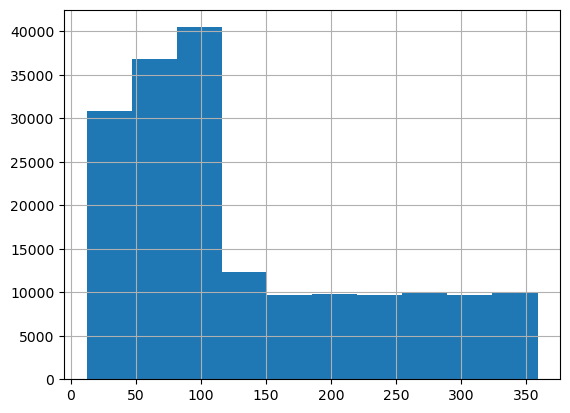

In [16]:
df['Loan Tenure'].hist()

In [ ]:
# ada nilai yang perlu diamati pada two wheeler loan yang jangkanya diatas 120 ini tidak masuk akal
#karena sepertinya untuk two wheeler tidak ada repayment diatas 10 tahun kecuali untuk rumah

In [17]:
len(df[df['Loan Tenure'] > 120]['Loan Tenure'])/len(df)
# dan persentasenya cukup besar

0.3758280180069481

<AxesSubplot:xlabel='Loan Tenure', ylabel='Credit Score'>

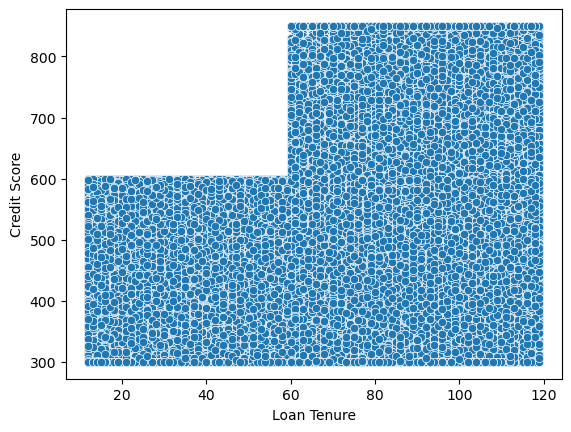

In [13]:
ds = df[df['Loan Tenure'] < 120]
sns.scatterplot(x=ds['Loan Tenure'],y=ds['Credit Score'])

<AxesSubplot:xlabel='Loan Tenure', ylabel='Credit Score'>

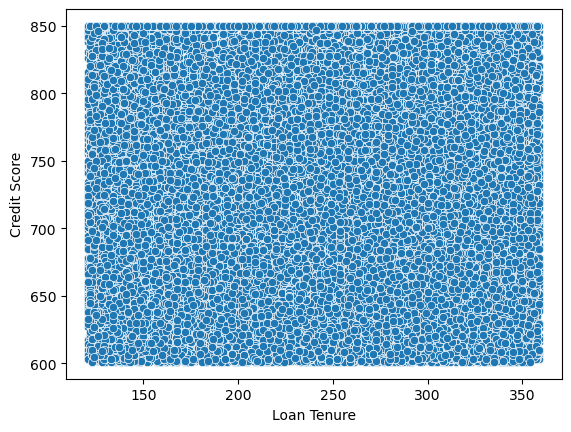

In [14]:
ds = df[df['Loan Tenure'] > 120]
sns.scatterplot(x=ds['Loan Tenure'],y=ds['Credit Score'])

In [8]:
# drop nilai aneh, sangat disayangkan
df = df[df['Loan Tenure'] <= 120]

In [9]:
#skewness check
df[numeric].skew()

Age                         0.065850
Income                      0.825368
Credit Score                0.691310
Credit History Length       0.011308
Number of Existing Loans    0.811715
Loan Amount                -0.401424
Loan Tenure                -0.170077
LTV Ratio                  -0.257918
Profile Score              -0.459229
Property Value              0.456639
dtype: float64

In [ ]:
# masih dianggap normal jika mengacu batas skew 2.0 dan -2.0

In [21]:
#category feature
df[category].describe()

,Gender,Existing Customer,State,City,Employment Profile,Occupation
count,111753,111753,111753,111753,111753,111753
unique,3,2,10,23,5,15
top,Female,No,West Bengal,Kolkata,Salaried,Banker
freq,51747,98147,11327,9696,52837,10763


In [ ]:
# gender ada other namun kita abaikan dulu dalam model
#existing customer binary

In [18]:
# check value category
for i in category:
    print(df[i].value_counts())

Female    51747
Male      51668
Other      8338
Name: Gender, dtype: int64
No     98147
Yes    13606
Name: Existing Customer, dtype: int64
West Bengal      11327
Uttar Pradesh    11248
Maharashtra      11228
Kerala           11227
Karnataka        11218
Tamil Nadu       11216
Delhi            11178
Gujarat          11111
Telangana        11085
Rajasthan        10915
Name: State, dtype: int64
Kolkata               9696
New Delhi             9528
Hyderabad             9336
Mysuru                4956
Thiruvananthapuram    4850
Lucknow               4808
Kanpur                4777
Surat                 4773
Udaipur               4748
Coimbatore            4738
Chennai               4698
Ahmedabad             4656
Kochi                 4629
Jaipur                4581
Bengaluru             4547
Manjari               3426
Dhulagori             3419
Bishanpura            3357
Nellikuppam           3333
Channarayapatna       3310
Mumbai                3298
Nagpur                3181
Pune       

In [9]:
#outlier check
# d_skew = [i for i in numeric]
# outlier = check_outliers(d_skew,df)

# not use this because the value is too little and reasonable for model variation

### DATA VISUALIZATION

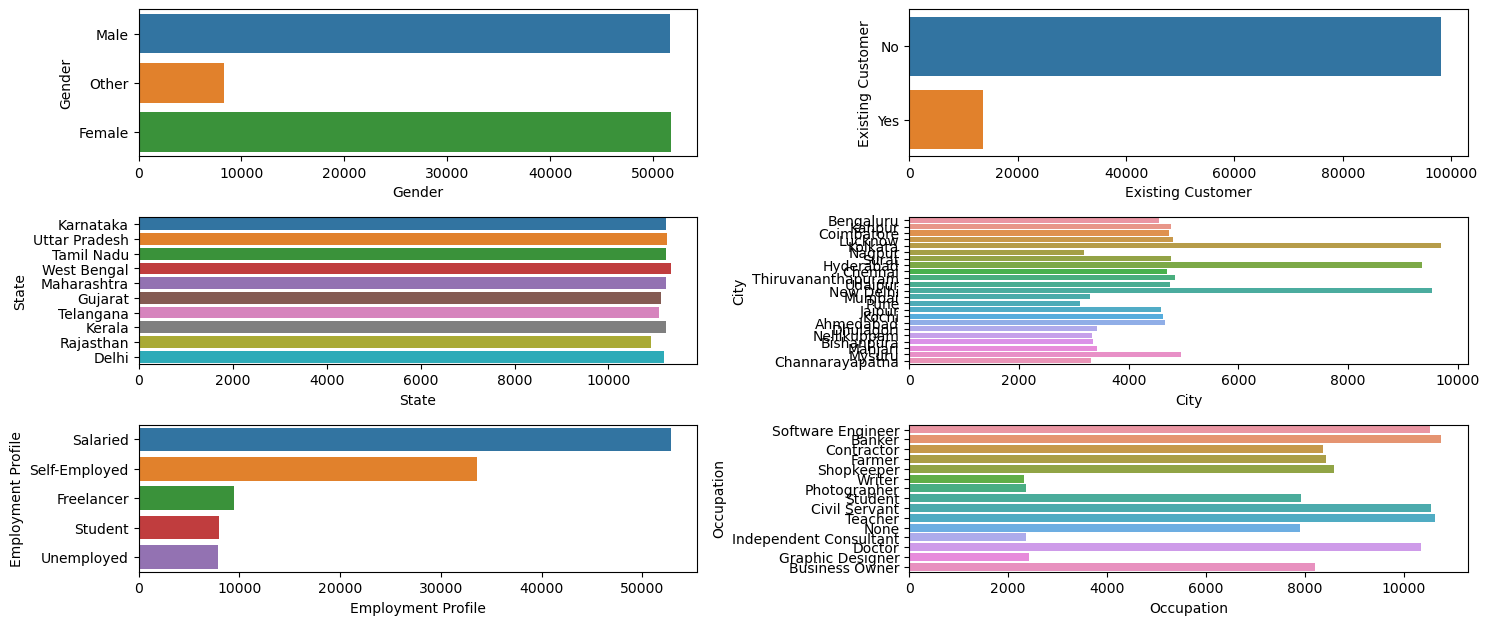

In [10]:
#category UNIVARIATE

plt.figure(figsize=(15,8))
index = 1

for i in category:
    plt.subplot(4,len(category)//3,index)
    sns.countplot(y=df[i])
    index += 1
    plt.xlabel(i)
    plt.tight_layout()

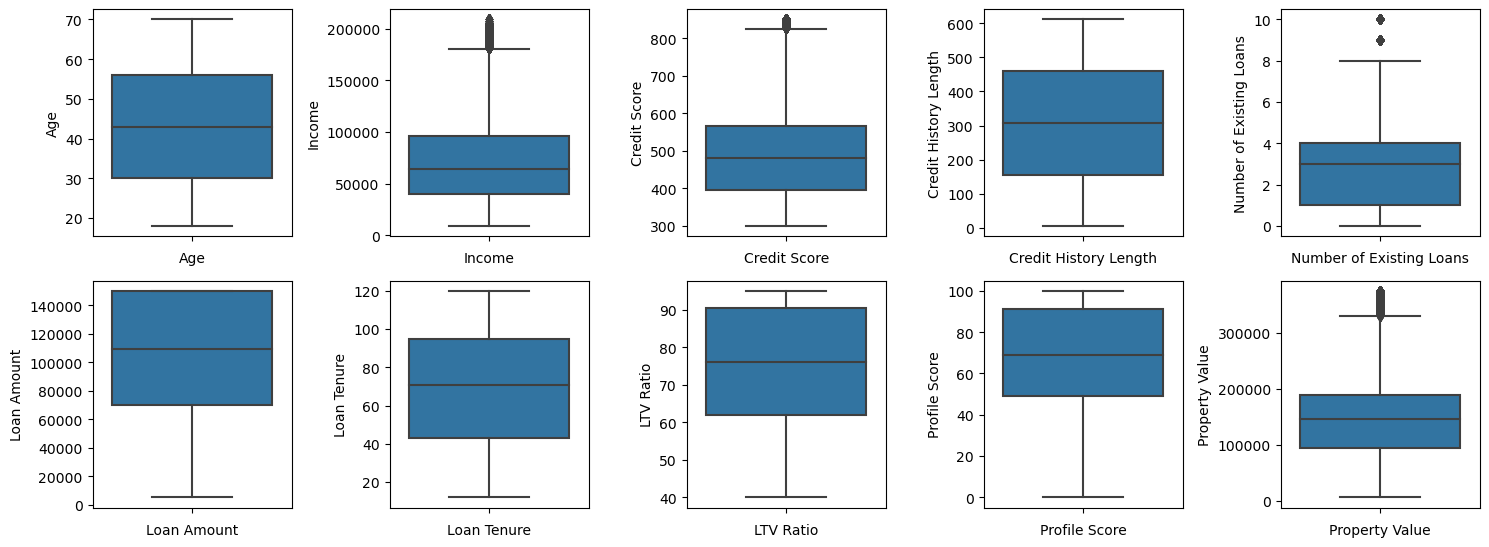

In [11]:
plt.figure(figsize=(15,8))
index = 1

for i in numeric:
    plt.subplot(3,len(numeric)//2,index)
    sns.boxplot(y=df[i])
    index += 1
    plt.xlabel(i)
    plt.tight_layout()

In [21]:
# down = values[0][1] 
# s = df[df['Profile Score'].isin(down)]
# plt.figure(figsize=(3,4))
# index = 1
# sns.scatterplot(x=s['Profile Score'],y= s['Profile Score'])

In [8]:
# df = df[~(df['Profile Score'].isin(down))]

### EDA VISUAL

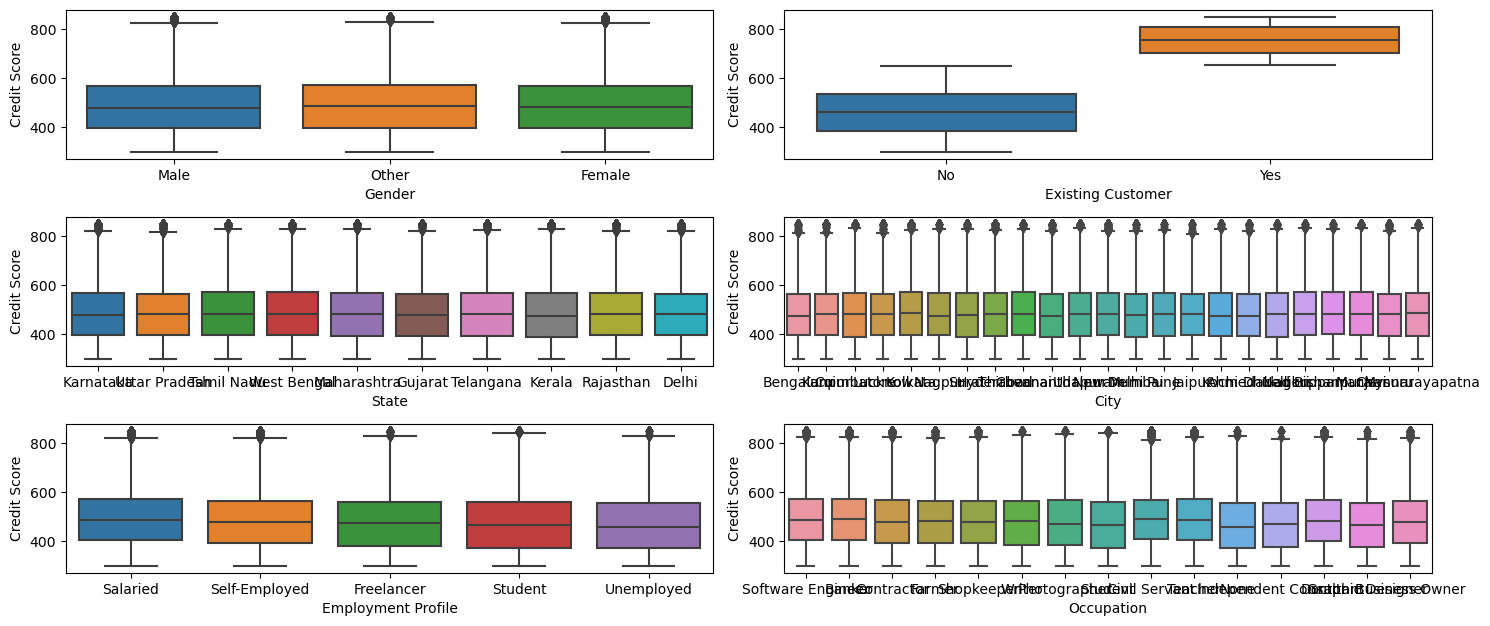

In [12]:
plt.figure(figsize=(15,8))
index = 1

for i in category:
    plt.subplot(4,len(category)//3,index)
    sns.boxplot(x=df[i],y=df['Credit Score'])
    index += 1
    plt.xlabel(i)
    plt.tight_layout()

In [ ]:
#existing customer yes memiliki credit score yang lebih tinggi daripada no 
#selain itu tidak ada insight jelas disini karena distribusi tidak berbeda jauh antar value kemungkinan juga fitur tidak
# berguna untuk model

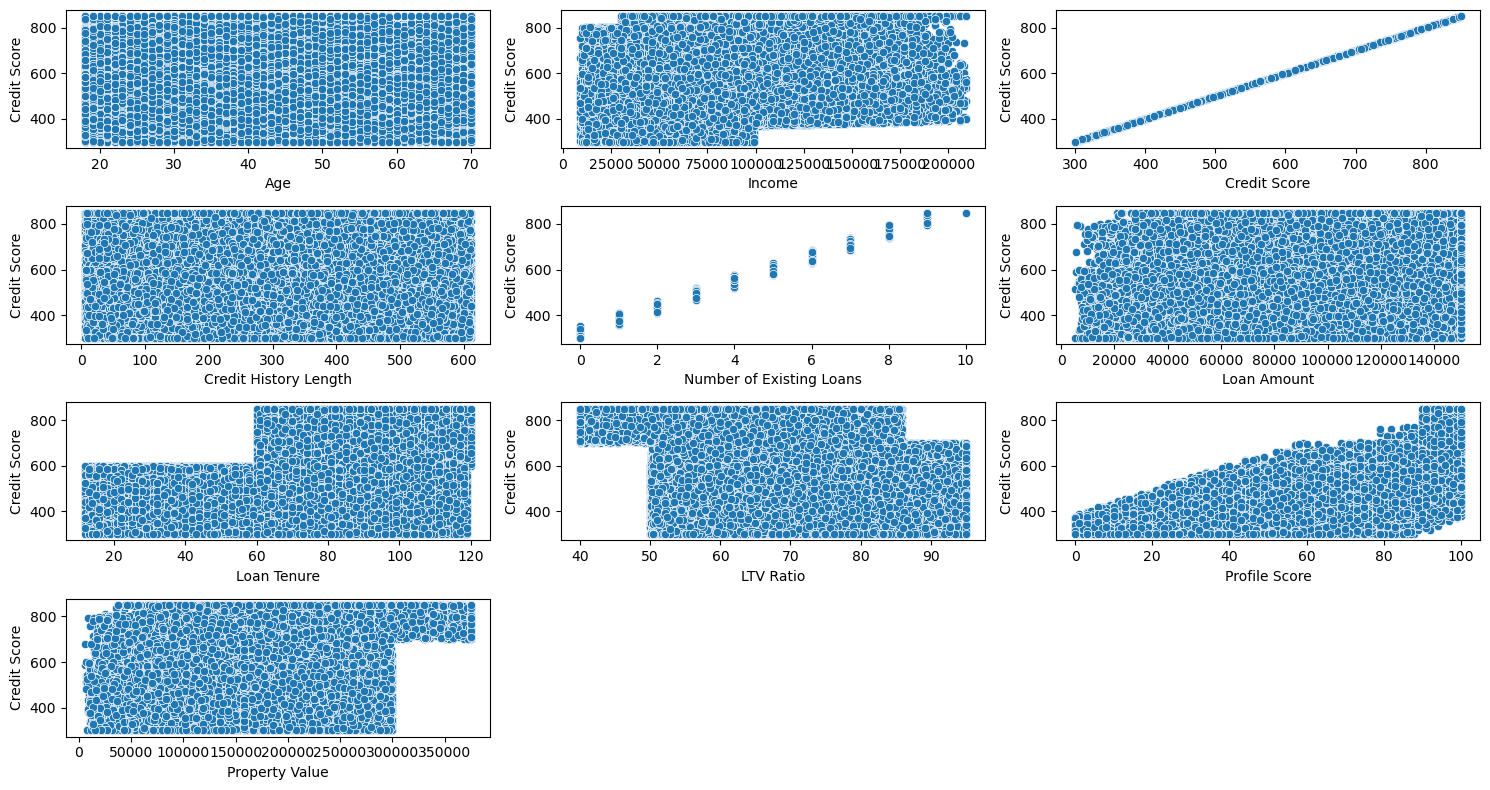

In [13]:
plt.figure(figsize=(15,8))
index = 1

for i in numeric:
    plt.subplot(4,len(numeric)//3,index)
    sns.scatterplot(x=df[i],y=df['Credit Score'])
    index += 1
    plt.xlabel(i)
    plt.tight_layout()

In [ ]:
# semakin tinggi profile score maka semakin tinggi credit score, mungkin karena memang profile score yang lebih tinggi 
#lebih dipercaya namun profile score dapat dipakai untuk model jika dalam realnya dapat diketahui atau pengetahuan penilaian
#profile score akan didrop

#number of existing loans semakin tinggi semakin tinggi credit score
#loan tenure dibawah 50 kebanyakan credit score 600 kebawah (atau jangka pembayaran sekitar 4 tahun)
#ltv ratio dibawah 50% tidak ada yang credit scorenya dibawah 700

In [24]:
df[df['LTV Ratio'] <= 50]['Credit Score'].min()

701

In [25]:
df[df['LTV Ratio'] >= 86]['Credit Score'].max()

700

In [27]:
df[df['Profile Score'] <=5]['Credit Score'].max()

401

In [90]:
df[df['Property Value'] <25300]['Credit Score'].max()

810

In [99]:
df[df['Property Value'] > 300000]['Credit Score'].min()

701

### SPLIT DATA

In [9]:
train,test = train_test_split(df,test_size= 0.20,random_state=1)

In [10]:
X_train = train[[i for i in train.columns if i != 'Credit Score']]
y_train = train['Credit Score']

In [11]:
X_test = test[[i for i in df.columns if i != 'Credit Score']]
y_test = test['Credit Score']

In [77]:
X_train.shape

(89402, 14)

In [78]:
X_test.shape

(22351, 14)

### FEATURE ENGINEERING

In [113]:
# condition = [
#     df2['Employment Profile'] == 'Salaried',
#     df2['Employment Profile'] == 'Self-Employed',
#     df2['Employment Profile'] == 'Freelancer',
#     df2['Employment Profile'] == 'Student', 
# ]

# choice = ['Salaried','Non Salaried','Non Salaried','Student']

# df2['Employment Profile'] = np.select(condition,choice,default=df2['Employment Profile'])

In [58]:
# dummies_occupation = pd.get_dummies(df2['Occupation'],dtype=int)
# df2 = pd.concat([df2,dummies_occupation],axis=1)

In [12]:
# Employment profile

dummies_employ = pd.get_dummies(X_train['Employment Profile'],dtype=int)
X_train = pd.concat([X_train,dummies_employ],axis=1)

dummies_employ_test = pd.get_dummies(X_test['Employment Profile'],dtype=int)
X_test = pd.concat([X_test,dummies_employ_test],axis=1)

In [13]:
encoder = LabelEncoder()
X_train['Employment Profile'] = encoder.fit_transform(X_train['Employment Profile'])
X_test['Employment Profile'] = encoder.fit_transform(X_test['Employment Profile'])

In [15]:
# df2['LTV Ratio'] = df2['LTV Ratio'] ** 2
 
condition = [
    X_train['Property Value'] <= 25500,
    (X_train['Property Value']> 25500) & (X_train['Property Value'] <=300000),
    (X_train['Property Value'] > 300000),
]
choice = ['Below25500','25500:300000','Above300000']
X_train['Property Value'] = np.select(condition,choice,X_train['Property Value'])
X_train['Property Value'].unique()

array(['25500:300000', 'Above300000', 'Below25500'], dtype=object)

In [16]:
dummies_pv = pd.get_dummies(X_train['Property Value'],dtype= int)
X_train = pd.concat([X_train,dummies_pv], axis=1)

In [17]:
condition = [
    X_test['Property Value'] <= 25500,
    (X_test['Property Value']> 25500) & (X_test['Property Value'] <=300000),
    (X_test['Property Value'] > 300000),
]
choice = ['Below25500','25500:300000','Above300000']
X_test['Property Value'] = np.select(condition,choice,X_test['Property Value'])
# X_test['Property Value'] = X_test['Property Value'].astype(int)
X_test['Property Value'].unique()

array(['25500:300000', 'Above300000', 'Below25500'], dtype=object)

In [18]:
dummies_pvtest = pd.get_dummies(X_test['Property Value'],dtype= int)
X_test = pd.concat([X_test,dummies_pvtest], axis=1)

### FEATURING

In [19]:
df2 = pd.concat([X_train,y_train],axis=1)

#### binary

In [20]:
# existing customer
df2['Existing Customer'] = np.where(df2['Existing Customer'] == 'Yes',1, 0)
X_test['Existing Customer'] = np.where(X_test['Existing Customer'] == 'Yes',1,0)

df2['Gender'] = np.where(df2['Gender'] == 'Male', 1,0)
X_test['Gender'] = np.where(X_test['Gender'] == 'Male', 1,0)

#### else

In [21]:
# drop variabel yang nampaknya tidak fungsional
df2 = df2.drop(['Credit History Length','Gender'],axis=1)
X_test = X_test.drop(['Credit History Length','Gender'],axis=1)

In [28]:
# loan amount
# df2 = df2.drop('Loan Amount', axis=1)
# X_test = X_test.drop('Loan Amount',axis=1)

In [22]:
#multicolinearity age
condition = [
    df2['Age'] <= 31,
    (df2['Age'] > 31) & (df2['Age'] <=44),
    (df2['Age'] > 44) & (df2['Age'] <=57),
    (df2['Age'] > 57),
]
choice = ['<=31','32-44','45-57','>57']
df2['Age'] = np.select(condition,choice,df2['Age'])
df2['Age'].unique()

array(['45-57', '32-44', '>57', '<=31'], dtype=object)

In [23]:
encoder = LabelEncoder()
df2['Age'] = encoder.fit_transform(df2['Age'])
df2['Age'].unique()

array([1, 0, 3, 2])

In [24]:
condition = [
    X_test['Age'] <= 31,
    (X_test['Age'] > 31) & (X_test['Age'] <=44),
    (X_test['Age'] > 44) & (X_test['Age'] <=57),
    (X_test['Age'] > 57),
]
choice = ['<=31','32-44','45-57','>57']
X_test['Age'] = np.select(condition,choice,X_test['Age'])
X_test['Age'] = encoder.fit_transform(X_test['Age'])

In [25]:
#transformation exponential

# df2['Profile Score'] = df2['Profile Score'] ** 2

df2 =df2.drop('Profile Score',axis=1)
X_test = X_test.drop('Profile Score',axis = 1)

#### check correl and multicolinearity

<AxesSubplot:>

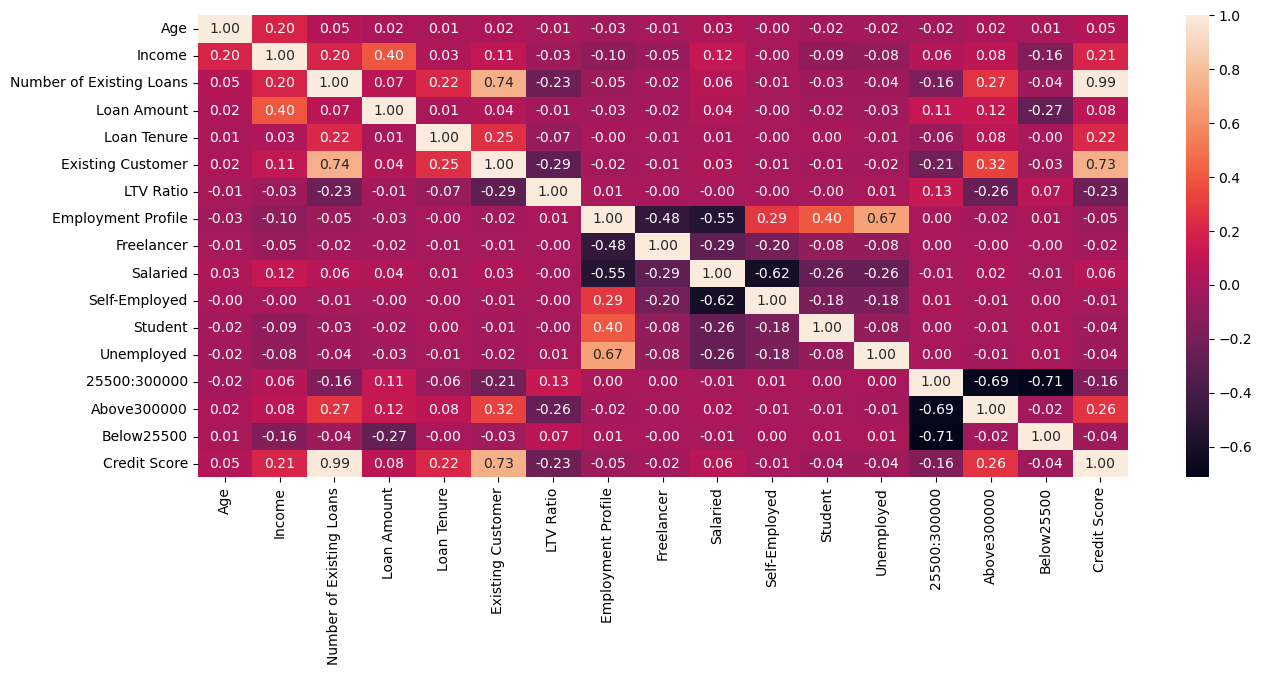

In [26]:
plt.figure(figsize=[15,6])
ds = df2.select_dtypes(include=[float,int])
corr = ds.corr()
sns.heatmap(corr,annot=True,fmt='.2f')

In [27]:
# not continous
nc = ['Existing Customer','Credit Score','Gender'] + list(dummies_pv) + list(dummies_employ)

In [28]:
# VIF ANALYSYS
X_matriks = ds[[i for i in ds.columns  if i not in nc]]
VIF_table(X_matriks)

,col,val
0,Age,2.863875
1,Income,5.248820
2,Number of Existing Loans,2.840239
3,Loan Amount,8.133596
4,Loan Tenure,5.740850
5,LTV Ratio,9.947735
6,Employment Profile,3.317361


### save cleaned data

In [301]:
# #save cleaned data
# ds.to_csv('cleaned_dataset.csv')

#### Premodel

In [32]:
# train data
col = list(df2.select_dtypes(include=[int,float]))
X_train = df2[col[0:-1]]
y_train = df2[col[-1]]
X_test = X_test[[i for i in col if i != 'Credit Score']]

In [33]:
X_train.head(1)

,Age,Income,Number of Existing Loans,Loan Amount,Loan Tenure,Existing Customer,LTV Ratio,Employment Profile,Freelancer,Salaried,Self-Employed,Student,Unemployed,25500:300000,Above300000,Below25500
29920,1,86000,0,114651,50,0,95.0,1,0,1,0,0,0,1,0,0


In [34]:
X_test.head(1)

,Age,Income,Number of Existing Loans,Loan Amount,Loan Tenure,Existing Customer,LTV Ratio,Employment Profile,Freelancer,Salaried,Self-Employed,Student,Unemployed,25500:300000,Above300000,Below25500
79464,3,114000,7,134333,108,1,70.28838,1,0,1,0,0,0,1,0,0


#### FEATURE SCALING

In [258]:
X_train.columns

Index(['Age', 'Income', 'Number of Existing Loans', 'Loan Amount',
       'Loan Tenure', 'Existing Customer', 'LTV Ratio', 'Freelancer',
       'Salaried', 'Self-Employed', 'Student', 'Unemployed', '25500:300000',
       'Above300000', 'Below25500'],
      dtype='object')

In [35]:
sc = StandardScaler()

col = [i for i in X_train.columns if i not in nc]
cc = [ i for i in nc if i not in ['Credit Score','Gender']]     
scaled = sc.fit_transform(X_train[col])
scaled = pd.DataFrame(scaled)
scaled.columns = col
X_train_scaled = pd.concat([scaled,X_train[cc].reset_index(drop=True)],axis=1)

test_scaled = sc.transform(X_test[col])
test_scaled = pd.DataFrame(test_scaled)
test_scaled.columns = col
X_test_scaled = pd.concat([test_scaled,X_test[cc].reset_index(drop=True)],axis=1)

In [295]:
# # save scaling 
# with open('standarscaler.pkl','wb')as file:
#     pickle.dump(sc,file)

In [281]:
X_train_scaled.columns

Index(['Age', 'Income', 'Number of Existing Loans', 'Loan Amount',
       'Loan Tenure', 'LTV Ratio', 'Existing Customer', '25500:300000',
       'Above300000', 'Below25500', 'Freelancer', 'Salaried', 'Self-Employed',
       'Student', 'Unemployed'],
      dtype='object')

### MODELING

In [36]:
model = {
    'lr': LinearRegression(),
    'ridge': Ridge(),
    'XGB': XGBRegressor(),
    'Lasso': Lasso()
}

param = {
    'lr': {},
    'XGB':{
        'random_state': [1]
    },
    'ridge':{
        'random_state': [1],
        'max_iter': [1000]
    },
    'Lasso':{
        'random_state': [1],
        'max_iter': [1000]
    },
    'SGD':{
        'random_state': [1],
        'max_iter': [1000]
    },
}

In [39]:
models = {}
test_predict = {}
for i in model.keys():
    gridsearch = GridSearchCV(estimator=model[i],param_grid= param[i],scoring='neg_mean_squared_error',cv=5)
    gridsearch.fit(X_train_scaled,y_train)
    y_pred_train = gridsearch.predict(X_train_scaled)
    models[i] = pd.DataFrame(gridsearch.cv_results_)
    models[i]['RMSE'] = np.sqrt(mean_squared_error(y_train,y_pred_train))
    models[i]['R_square'] = r2_score(y_train,y_pred_train)
    y_pred = gridsearch.predict(X_test_scaled)
    test_predict[i] = {'MSE': np.mean(y_test - y_pred) **2, 'RMSE': np.sqrt(np.mean(y_test - y_pred)**2),'R_Square':r2_score(y_test,y_pred)}

In [40]:
# the results
results = pd.concat(models.values(), ignore_index=True)
results['model'] = [i for i in model]
results
retain_cols = ['model','params','mean_test_score','RMSE','R_square']
results[retain_cols]
results[retain_cols].sort_values('RMSE')

,model,params,mean_test_score,RMSE,R_square
2,XGB,{'random_state': 1},-223.463043,14.113205,0.988815
1,ridge,"{'max_iter': 1000, 'random_state': 1}",-281.200760,16.767517,0.984212
0,lr,{},-281.212393,16.767662,0.984212
3,Lasso,"{'max_iter': 1000, 'random_state': 1}",-283.251813,16.829727,0.984095


In [37]:
# baseline

# model	params	mean_test_score	RMSE
# 2	XGB	{'random_state': 1}	-223.805590	14.173075
# 0	lr	{}	-281.411770	16.774377
# 1	ridge	{'max_iter': 1000, 'random_state': 1}	-281.411767	16.774377
# 3	Lasso	{'max_iter': 1000, 'random_state': 1}	-281.753333	16.784945

#employment profile encode label encoder
# 	model	params	mean_test_score	RMSE
# 2	XGB	{'random_state': 1}	-223.301379	14.121867
# 0	lr	{}	-281.311525	16.771141
# 1	ridge	{'max_iter': 1000, 'random_state': 1}	-281.311522	16.771141
# 3	Lasso	{'max_iter': 1000, 'random_state': 1}	-281.753333	16.784945

# employment onehot & fitur property value
# model	params	mean_test_score	RMSE
# 2	XGB	{'random_state': 1}	-223.283005	14.089511
# 0	lr	{}	-281.200770	16.767517
# 1	ridge	{'max_iter': 1000, 'random_state': 1}	-281.200757	16.767517
# 3	Lasso	{'max_iter': 1000, 'random_state': 1}	-281.753333	16.784945

# model	params	mean_test_score	RMSE	R_square
# 2	XGB	{'random_state': 1}	-223.463043	14.113205	0.988815
# 1	ridge	{'max_iter': 1000, 'random_state': 1}	-281.200760	16.767517	0.984212
# 0	lr	{}	-281.212393	16.767662	0.984212
# 3	Lasso	{'max_iter': 1000, 'random_state': 1}	-283.251813	16.829727	0.984095

In [41]:
# test predict
pd.DataFrame(test_predict) 

,lr,ridge,XGB,Lasso
MSE,0.000141,0.000139,0.000056,0.000018
RMSE,0.011876,0.011783,0.007458,0.004299
R_Square,0.983906,0.983904,0.987276,0.983770


In [ ]:
# baseline

# lr	ridge	XGB	Lasso
# MSE	0.000017	0.000017	0.000116	0.000016
# RMSE	0.004157	0.004174	0.010756	0.004036

# employment profile encode
# lr	ridge	XGB	Lasso
# MSE	0.000068	0.000068	0.000018	0.000069
# RMSE	0.008226	0.008224	0.004238	0.008313

#onehot employment & fitur property value
# lr	ridge	XGB	Lasso
# MSE	0.000139	0.000139	0.000075	0.000069
# RMSE	0.011802	0.011795	0.008648	0.008313

# lr	ridge	XGB	Lasso
# MSE	0.000141	0.000139	0.000056	0.000018
# RMSE	0.011876	0.011783	0.007458	0.004299
# R_Square	0.983906	0.983904	0.987276	0.983770

### TUNNING

In [289]:
xgb = XGBRegressor()
param = {
    'random_state':[1],
    'max_depth': [18],
    'max_leaves':[2],
    
}

gridsearch = GridSearchCV(estimator=xgb,param_grid= param,scoring='neg_mean_squared_error',cv=5)
gridsearch.fit(X_train_scaled,y_train)
cc = pd.DataFrame(gridsearch.cv_results_)
cc

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaves,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,26.596749,0.409495,0.360404,0.010234,18,2,1,"{'max_depth': 18, 'max_leaves': 2, 'random_sta...",-124.921376,-129.261593,-125.330873,-125.153532,-129.814408,-126.896357,2.16786,1


### FINAL MODEL

In [290]:
xgb = XGBRegressor(random_state=1,max_depth=18,max_leaves=2)
model = xgb.fit(X_train_scaled,y_train)
y_pred = model.predict(X_train_scaled)
mse = mean_squared_error(y_train,y_pred)
rmse = np.sqrt(mse)
print(f'MSE : {mse}\nrmse:{rmse}')

MSE : 1.6296547424655803
rmse:1.2765793130336949


In [291]:
y_pred_test = model.predict(X_test_scaled)
mse = mean_squared_error(y_test,y_pred_test)
rmse = np.sqrt(mse)
print(f'MSE : {mse}\nrmse: {rmse}')

MSE : 92.63110780961955
rmse: 9.624505587801357


Age: 0.0004125804698560387
Income: 0.0007541670929640532
Number of Existing Loans: 0.973702609539032
Loan Amount: 0.0011487500742077827
Loan Tenure: 0.001180398860014975
LTV Ratio: 0.0013170393649488688
Existing Customer: 0.01226069312542677
25500:300000: 0.0015485797775909305
Above300000: 0.0016349423676729202
Below25500: 0.0
Freelancer: 0.0012320379028096795
Salaried: 0.0009611219866201282
Self-Employed: 0.0011249660747125745
Student: 0.0013579789083451033
Unemployed: 0.0013641470577567816


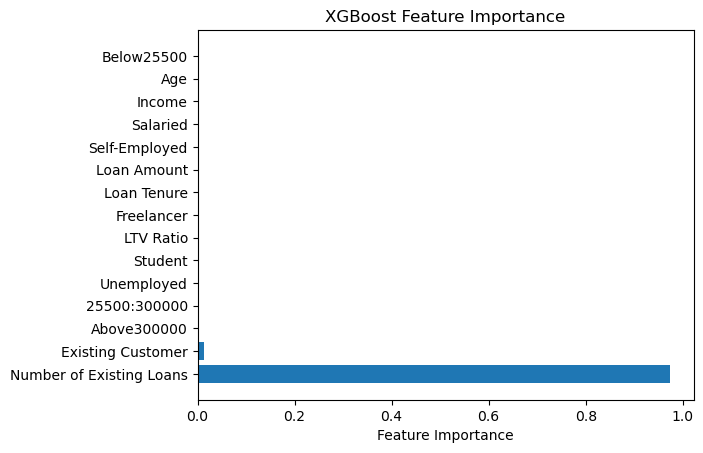

In [292]:
importances = model.feature_importances_

for feature_name, importance in zip(X_train_scaled.columns, importances):
    print(f"{feature_name}: {importance}")
    
sorted_idx = np.argsort(importances)[::-1]
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_train_scaled.columns[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()

In [ ]:
# feature importances focus on existing customer and number of existing loan very very important to predict credit score

In [296]:
# #save XGB model

# with open('modelXGB.pkl','wb') as file:
#     pickle.dump(model,file)